In [2]:
## Attaches burn probabilities to the ZTRAX data
## Uses lat and long provided 
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

In [3]:
## Get US Map for context and select Western United States
##Convert Coordinate Reference System to US Natinoal Atlas Equal Area
USMAP = gpd.read_file('/data/yoder/DensityProject/cb_2018_us_state_500k.shp')
USMAP = USMAP.to_crs("EPSG:2163")
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']

## Get map(s) of individual states if desired
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

In [4]:
scratchpath = '/scratch/user/joshua.olsen/20210428_153601/'
os.chdir(scratchpath)
## List all tables included in Zillow Variable names excel file
ZTransLayout = pd.read_excel('Layout.xlsx','ZTrans')
ZTransLayout['TableName'].unique()
ZAsmtLayout = pd.read_excel('Layout.xlsx','ZAsmt')

## Create dataframes from each table name in the Zillow table dictionary
    ## Strip 'ut' from column names
T = {}
for name,group in ZTransLayout.groupby('TableName'):
    T[str(name)[2:]] = group
A = {}
for name, group in ZAsmtLayout.groupby('TableName'):
    A[str(name)[2:]] = group
    
    
## Dictionary of Western 11 states using Zillows numbering: 
states = {'AZ':'04',
          'CA':'06',
          'CO':'08',
          'ID':'16',
          'MT':'30',
          'NV':'32',
          'NM':'35',
          'OR':'41',
          'UT':'49',
          'WA':'53',
          'WY':'56'}

In [5]:
#Change this value to the state and table you care about
# State to use
state = states['WA']
state_map = USMAP[USMAP['STUSPS']=='WA']
#Transaction tables to use
Ttables = ['Main', 'PropertyInfo']
# Assessment tables to use
Atables = ['Main','Garage', 'Building']

In [6]:
## Fields to use from transaction tables
Tfields = {'Main': ['TransId','State','County','DocumentDate','SignatureDate',
                    'RecordingDate','FIPS','DataClassStndCode',
                    'DocumentTypeStndCode','IntraFamilyTransferFlag',
                    'LoanTypeStndCode','PropertyUseStndCode',
                    'SalesPriceAmount', 'LoanAmount'],
            'PropertyInfo':['TransId','ImportParcelID','AssessorParcelNumber',
                            'PropertyFullStreetAddress','PropertyCity',
                            'PropertyState','PropertyAddressLatitude',
                            'PropertyAddressLongitude']}
# Fields to use from Assessment tables
Afields = {'Main': ['RowID','ImportParcelID','LotSizeSquareFeet'],
          'Garage':['RowID','GarageStndCode','GarageAreaSqFt'],
          'Building':['RowID','ArchitecturalStyleStndCode','BuildingClassStndCode','BuildingQualityStndCode',
                       'BuildingConditionStndCode','EffectiveYearBuilt','YearBuilt','YearRemodeled',
                       'NoOfStories','TotalRooms','TotalBedrooms','TotalKitchens',
                       'FullBath','ThreeQuarterBath','HalfBath','QuarterBath','TotalActualBathCount',
                       'TotalBathPlumbingFixtures','RoofCoverStndCode', 'RoofStructureTypeStndCode',
                       'HeatingTypeorSystemStndCode','AirConditioningTypeorSystemStndCode',
                       'FoundationTypeStndCode','ElevatorStndCode','FireplaceFlag',
                       'FireplaceNumber','WaterStndCode','SewerStndCode','TimeshareStndCode',                       ]} 
## Throws error if these are included 'FireplaceTypeStndCode','StoryTypeCode'

In [7]:
%%time
## Load Ztrans data into dictionary of table entries that will be merged
dfs = {}
keys = Ttables
for i in keys:
    # Populate dictionary with desired tables for the given state
    dfs[i] = pd.read_csv(f'{state}/ZTrans\{i}.txt',sep = '|', header=None,names=T[i]['FieldName'].tolist(), encoding='latin1',usecols=Tfields[i]) 

<decorator-gen-54>:2: DtypeWarning: Columns (18,30) have mixed types.Specify dtype option on import or set low_memory=False.
<decorator-gen-54>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 1s, sys: 4.66 s, total: 1min 6s
Wall time: 1min 20s


In [8]:
%%time
## Load Assessor data

dfA = {}
keys = Atables
for j in keys:
    dfA[j] = pd.read_csv(f'{state}/ZAsmt\{j}.txt',sep='|', header=None,names=A[j]['FieldName'].tolist(),encoding='latin1',usecols=Afields[j])

<decorator-gen-54>:2: DtypeWarning: Columns (9,10,12,13,29,30,31,32,33,34,35,38,39) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 22.2 s, sys: 2.06 s, total: 24.3 s
Wall time: 29.5 s


In [9]:
## Merge Trans tables and Asmt tables
from functools import reduce
Trans = reduce(lambda left,right: pd.merge(left,right,on='TransId',how='left'),dfs.values())
Asmt = reduce(lambda left, right:pd.merge(left,right,on='RowID',how='left'),dfA.values())
df = pd.merge(Trans,Asmt,on='ImportParcelID',how='left')

In [10]:
## Select only valid transactions
UnwantedLoanCodes =  ['AC','CT','CM','CS','CC','CL','DP','FO','FE','HE','LC','EB','EX','MD','NA','NP','FA','RE','RM','SM','SE','TR']
WantedLoanCodes =  ['AS','BL','CE','FM','PM','RD','SL']
DocumentTypeStndCodeDrop= ['CRDE','JTDE','QCDE','RRDE','VLDE']
DocumentTypeStndCodeKeep= ['CPDE','IDDE','PRDE','WRDE']

st = df.loc[(df['SalesPriceAmount'] > 0) &
            (~df['LoanTypeStndCode'].isin(UnwantedLoanCodes)) &
            (pd.isnull(df['IntraFamilyTransferFlag'])) &
            (df['PropertyUseStndCode']=='SR') &
            (df['DocumentTypeStndCode'].isin(DocumentTypeStndCodeKeep)) & 
            (df['TotalBedrooms'] >=1)].copy()

In [11]:
st

,TransId,FIPS,State,County,DataClassStndCode,RecordingDate,DocumentTypeStndCode,DocumentDate,SignatureDate,SalesPriceAmount,...,RoofStructureTypeStndCode,HeatingTypeorSystemStndCode,AirConditioningTypeorSystemStndCode,FoundationTypeStndCode,ElevatorStndCode,FireplaceFlag,FireplaceNumber,WaterStndCode,SewerStndCode,TimeshareStndCode
83,356047715,53011,WA,CLARK,H,1995-01-12,WRDE,1995-01-09,NaN,106170.0,...,NaN,FA,NO,NaN,NaN,NaN,1.0,NaN,NaN,NaN
84,356047715,53011,WA,CLARK,H,1995-01-12,WRDE,1995-01-09,NaN,106170.0,...,NaN,FA,NO,NaN,NaN,NaN,1.0,NaN,NaN,NaN
101,356047723,53011,WA,CLARK,H,1995-01-12,WRDE,1995-01-10,NaN,91500.0,...,NaN,BB,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,356047723,53011,WA,CLARK,H,1995-01-12,WRDE,1995-01-10,NaN,91500.0,...,NaN,BB,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,355790418,53005,WA,BENTON,H,2005-01-18,WRDE,2005-01-12,NaN,129900.0,...,GBL,CE,CE,CS,NaN,NaN,NaN,YY,YY,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18042415,438193552,53033,WA,KING,H,2018-07-24,WRDE,2018-07-18,NaN,445000.0,...,NaN,FA,NaN,NaN,NaN,NaN,1.0,MU,YY,NaN
18042416,438193553,53033,WA,KING,H,2018-07-24,WRDE,2018-07-12,NaN,518000.0,...,NaN,EL,NaN,NaN,NaN,NaN,NaN,MU,PU,NaN
18042417,438193553,53033,WA,KING,H,2018-07-24,WRDE,2018-07-12,NaN,518000.0,...,NaN,EL,NaN,NaN,NaN,NaN,NaN,MU,PU,NaN
18042430,438193561,53033,WA,KING,H,2018-07-24,WRDE,2018-07-18,NaN,350000.0,...,NaN,FA,NaN,NaN,NaN,NaN,1.0,MU,PU,NaN


In [12]:
## Make geodataframe

st = gpd.GeoDataFrame(st, geometry = gpd.points_from_xy(st.PropertyAddressLongitude, st.PropertyAddressLatitude))
st_proj = st.copy()
st_proj.crs="epsg:4326"
st_proj=st_proj.to_crs("EPSG:2163")
st_proj.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [13]:
import rasterio
from rasterstats import zonal_stats, point_query
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [14]:
## Reproject raster and load it

dst_crs ="EPSG:2163"

with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
                   reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                
src = rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

/home/joshua.olsen/.conda/envs/testenv/lib/python3.8/site-packages/matplotlib/image.py:490: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


<AxesSubplot:>

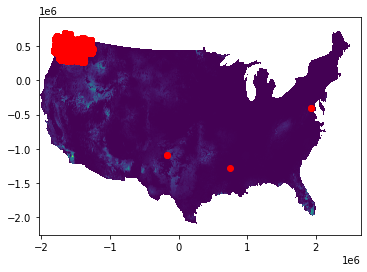

In [15]:
fig, ax = plt.subplots()
show(src,ax = ax)
st_proj.plot(ax=ax, color ='red')

In [16]:
pts = st_proj.copy()

In [17]:
st_proj.shape

(1902355, 54)

In [18]:
## Select only valid geometry (note .isna() does not appear to catch point (nan,nan))
st_pts = st_proj[st_proj['geometry'].is_valid]
st_pts = gpd.clip(st_pts, state_map)

In [19]:
st_pts.shape

(1899781, 54)

<AxesSubplot:>

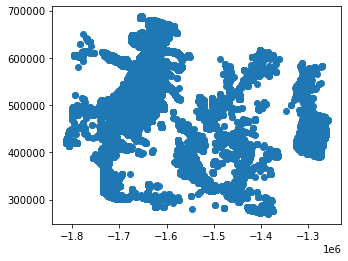

In [20]:
st_pts.plot()

In [21]:
pts = st_pts.copy()

In [22]:
%%time
## Add burn probability that the location is within (landfire uses 270 meter pixels)
pts['BP'] = point_query(pts, '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

CPU times: user 1h 7min 3s, sys: 3min 52s, total: 1h 10min 56s
Wall time: 1h 11min 2s


In [23]:
%%time
## Add burn probability out to 1600 meters
pts['point_geometry'] = pts['geometry'].copy()
pts['geometry'] = pts.buffer(1600)
buff = pd.DataFrame(zonal_stats(pts, 
                             '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif',
                            stats=['max','mean']))
buff.columns = [f'BP1600_'+str(col) for col in buff.columns]

buff.reset_index(drop=True,inplace=True)
pts.reset_index(drop=True,inplace=True)
pts = pd.concat([pts,buff],axis=1)
pts['geometry'] = pts['point_geometry'].copy()

/home/joshua.olsen/.conda/envs/testenv/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


CPU times: user 2h 1min 5s, sys: 8min, total: 2h 9min 6s
Wall time: 2h 9min 18s


In [24]:
BurnCols = ['BP','BP1600_max','BP1600_mean']

<AxesSubplot:>

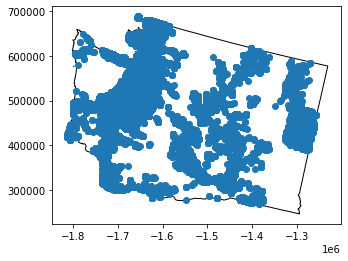

In [25]:
basemap = state_map.plot(edgecolor='black',color='white')
pts.plot(ax= basemap)

In [26]:
ST_points = pts.copy()

In [27]:
## Add fire perimeter data
import geopandas as gpd
Fireperims = gpd.read_file('/data/yoder/DensityProject/mtbs_perimeter_data/mtbs_perims_DD.shp')
Fireperims = Fireperims.to_crs("EPSG:2163")

In [28]:
state_map = state_map[['STUSPS', 'geometry']]
Buffed_state = state_map.copy()
Buffed_state['geometry'] = Buffed_state.buffer(100000)
ST_fires = gpd.sjoin(Fireperims, Buffed_state, op='within')
ST_fires = ST_fires.drop(['index_right'], axis=1)
ST_fires['Buffed_geometry100km'] = ST_fires.buffer(100000)
ST_fires['MTBS_geometry'] = ST_fires['geometry'].copy()
ST_fires['geometry'] = ST_fires['Buffed_geometry100km'].copy()

In [29]:
# ST_samp = pts.sample(n=10000)

<AxesSubplot:>

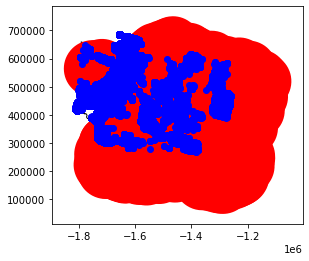

In [30]:
basemap = state_map.plot(edgecolor='black',color='white')
ST_fires.plot(ax=basemap, color='red')
ST_points.plot(ax= basemap, color='blue')

In [ ]:
## Find way to join points and burn probs

In [31]:
%%time
ST_Samp_with_Fires = gpd.sjoin(ST_points, ST_fires, how='left')

KeyboardInterrupt: 

In [ ]:
def get_distance(row):
    distance = row.geometry.distance(row.MTBS_geometry)
    return distance

In [ ]:
%%time
ST_Samp_with_Fires['Distance'] = ST_Samp_with_Fires.apply(lambda row: get_distance(row),axis=1)

In [ ]:
# ST_Samp_with_Fires['Distance'].describe()

In [ ]:
# pricy = ST_Samp_with_Fires.loc[ST_Samp_with_Fires['SalesPriceAmount']>=10000000]

In [ ]:
# pricy.drop_duplicates(subset=['TransId'])

In [ ]:
ST_Samp_with_Fires.describe()